In [ ]:
! pip install gensim
! pip install nltk
! pip install string
! pip install wordcloud
! pip install emoji
! pip install pyLDAvis
! pip install spacy
! python -m spacy download en_core_web_lg
! pip install regex

In [18]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [57]:

# ~~~~~~~~~~~~~~~~~~~~~~~~ IMPORTING REQUIRED PACKAGES ~~~~~~~~~~~~~~~~~~~~~~~

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import regex
import re
# For removing stop words, word tokenization, lemmatization -
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# Forming word cloud - getting word frequencies -
from nltk.probability import FreqDist
from wordcloud import WordCloud
from nltk.sentiment import SentimentIntensityAnalyzer
# Creating bag of words - 
from gensim.corpora import Dictionary
# LDA Model, and plotting it -
from gensim.models.ldamodel import LdaModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
import pyLDAvis.gensim
import gensim.corpora as corpora
# Replace emojis -
import emoji
from nltk.sentiment.vader import SentimentIntensityAnalyzer


In [20]:
# ~~~~~~~~~~~~~~~~~~~~~ INITIAL DATA CLEANING AND SORTING ~~~~~~~~~~~~~~~~~~~~

In [36]:
# Reading the data -
file_list = ['Data_Cleaning/May.csv','Data_Cleaning/Jun.csv']
df_total = pd.read_csv('Data_Cleaning/Apr.csv')
for file in file_list:
    temp = pd.read_csv(file)
    df_total.append(temp)
df_total.head()

,doc_id,text,created,team
0,1245348385542082560,RT @bladner_: Damian Jones played significantl...,2020-04-01 13:52:47,Atlanta Hawks
1,1245347338320822280,RT @LockedOnHawks: Good morning! Episode 740 ...,2020-04-01 13:48:37,Atlanta Hawks
2,1245346320812060673,Damian Jones played significantly more minutes...,2020-04-01 13:44:34,Atlanta Hawks
3,1245345847526768640,RT @tomjwade: OTD in @celtics history: 1973. ...,2020-04-01 13:42:42,Atlanta Hawks
4,1245345061749088258,OTD in @celtics history: 1973. John Havlicek ...,2020-04-01 13:39:34,Atlanta Hawks


In [37]:
# Getting count of teams -
team_count = pd.DataFrame(df_total['team'].value_counts().reset_index())
team_count.columns = ['team', 'tweets_count']
team_count.head()

,team,tweets_count
0,Chicago Bulls,27434
1,Miami Heat,23501
2,Boston Celtics,19841
3,Golden State Warriors,12374
4,Houston Rockets,12287


In [38]:
# Selecting the top 10 teams -
team_count = team_count.iloc[0:10]

In [39]:
# Plotting the number of tweets - 
# SALONI !!!!!!!!!

In [40]:
# From the plot we can see that there are top 3 teams.
# We trim the data to those 3 teams to save time of computation and visualize results -

In [41]:
# Selecting top 3 teams - 
team_count = team_count.iloc[0:3]
df = df_total[df_total['team'].isin(team_count['team'])]

In [42]:
# ~~~~~~~~~~~~~~~~~~~~~ CLEANING TEXT FOR ANALYSIS ~~~~~~~~~~~~~~~~~~~~

In [43]:
# Removing any URLs -
df['text'] = df['text'].str.replace(r"http\S+", "")

# Removing emojis -
def remove_emoji(text):
    return emoji.get_emoji_regexp().sub(u'', text)

# For topic modelling we remove the emojis - 
df['topic_modeling_text'] = df['text'].apply(remove_emoji)

# For sentiment analysis we rephrase the emojis -
df['sentiment_text'] = df['text'].apply(emoji.demojize)

# We get the general stop words for the english language.
stop_words = stopwords.words('english')

# Including the punctuations in the stop words -
stop_words += list(string.punctuation)

# Including numbers to the list of stop words -
stop_words += ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

# Removing further words, which we don't want - 
stop_words += ['’', '...', '…', '‘', "\'s", "\'\'", '“', '”', 'rt', 'wt...', 'w...', '``',
               'm...', 'say', '-', '_', '__','hi','\n','\n\n', '&amp;', ' ', '.', '-', '—',
               'got', "it's", 'it’s', "i'm", 'i’m', 'im', 'want', 'like', '$', '@']


<ipython-input-43-e42c990ad1f2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = df['text'].str.replace(r"http\S+", "")
<ipython-input-43-e42c990ad1f2>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['topic_modeling_text'] = df['text'].apply(remove_emoji)
<ipython-input-43-e42c990ad1f2>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

In [44]:
# Cleaning text for sentiment analysis ~~~~~~~~~~~~~~~~~~~~~

# Removing the names of the teams -
team_name = list(df['team'].unique())
for team in team_name:
   tokens = nltk.word_tokenize(team)
   stop_words += list(token.lower() for token in tokens)

# First step to remove the stop words and tokenize the text -
def first_clean_step(text):
    tokens = nltk.word_tokenize(text)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stop_words]
    return stopwords_removed

# Applying the function to all the rows -
df['sentiment_text'] = df['sentiment_text'].apply(first_clean_step)


# Initializing the Lemmatizer object -
lemmatizer = WordNetLemmatizer()

# Function to applt lemmatization to all the tweets in the df -
def lemmatize_text(df_text):
    lemmatized =[]
    for w in df_text:
        lemmatized.append(lemmatizer.lemmatize(w))
    return lemmatized

# Applying the function to each row -
df['sentiment_text'] = df['sentiment_text'].apply(lemmatize_text)

def second_clean_step(tokens):
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stop_words]
    return stopwords_removed

df['sentiment_text'] = df['sentiment_text'].apply(second_clean_step)

<ipython-input-44-e7421c243c53>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment_text'] = df['sentiment_text'].apply(first_clean_step)
<ipython-input-44-e7421c243c53>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment_text'] = df['sentiment_text'].apply(lemmatize_text)
<ipython-input-44-e7421c243c53>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

In [45]:
# Cleaning data for topic modelling ~~~~~~~~~~~~~~~~~~~~~~~

# Removing the names of the teams -
team_name = list(df['team'].unique())
for team in team_name:
   tokens = nltk.word_tokenize(team)
   stop_words += list(token.lower() for token in tokens)

# First step to remove the stop words and tokenize the text -
def first_clean_step(text):
    tokens = nltk.word_tokenize(text)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stop_words]
    return stopwords_removed

# Applying the function to all the rows -
df['cleaned_text'] = df['topic_modeling_text'].apply(first_clean_step)

# Initializing the Lemmatizer object -
lemmatizer = WordNetLemmatizer()

# Function to applt lemmatization to all the tweets in the df -
def lemmatize_text(df_text):
    lemmatized =[]
    for w in df_text:
        lemmatized.append(lemmatizer.lemmatize(w))
    return lemmatized

# Applying the function to each row -
df['cleaned_text'] = df['cleaned_text'].apply(lemmatize_text)

def second_clean_step(tokens):
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stop_words]
    return stopwords_removed

df['cleaned_text'] = df['cleaned_text'].apply(second_clean_step)

<ipython-input-45-2e6ae768ede8>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cleaned_text'] = df['topic_modeling_text'].apply(first_clean_step)
<ipython-input-45-2e6ae768ede8>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cleaned_text'] = df['cleaned_text'].apply(lemmatize_text)
<ipython-input-45-2e6ae768ede8>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [46]:
# ~~~~~~~~~~~~~~~~ SENTIMENTAL ANALYSIS OF ALL THE TEAMS ~~~~~~~~~~~~~~~

In [30]:
# Joining the token back into a sentence -
def join_sentiment_text(row):
    row = " ".join(row)
    return row
df['sentiment_text'] = df['sentiment_text'].apply(join_sentiment_text)

# Instatiating the sentiment intensity analyzer -
sid = SentimentIntensityAnalyzer()

# Finding sentiment of each tweet - 
df['sentiment_score'] = df['sentiment_text'].apply(lambda review: sid.polarity_scores(review))
df['compound_score']  = df['sentiment_score'].apply(lambda score_dict: score_dict['compound'])
df['sentiment'] = df['compound_score'].apply(lambda c: 1 if c >=0 else 0) # 1 - pos, 0 - neg

df.drop(['compound_score', 'sentiment_score'], axis = 1, inplace = True)

<ipython-input-30-fcf8d4ec17ed>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment_text'] = df['sentiment_text'].apply(join_sentiment_text)
<ipython-input-30-fcf8d4ec17ed>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment_score'] = df['sentiment_text'].apply(lambda review: sid.polarity_scores(review))
<ipython-input-30-fcf8d4ec17ed>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [ ]:
# GRAPH BY SALONI - 

In [ ]:
# ~~~~~~~~~~~~~~~~~~~~ ANALYSIS FOR TOPIC MODELLING ~~~~~~~~~~~~~~~~~~~~
# ~~~~~~~~~~~~~~ TWEETS LENGTH DISTRIBUTION AND WORDCLOUD ~~~~~~~~~~~~~~

In [47]:

temp = df.copy()


df = df.loc[df['team'] == 'Chicago Bulls']
df.head()

,doc_id,text,created,team,topic_modeling_text,sentiment_text,cleaned_text
3908,1245350271712026626,RT @ThrowbackHoops: No player introduction was...,2020-04-01 14:00:16,Chicago Bulls,RT @ThrowbackHoops: No player introduction was...,"[throwbackhoops, player, introduction, better]","[throwbackhoops, player, introduction, better]"
3909,1245350010813906945,BREAKING: Jim Boylen and the Bulls have mutual...,2020-04-01 13:59:14,Chicago Bulls,BREAKING: Jim Boylen and the Bulls have mutual...,"[breaking, jim, boylen, mutually, agreed, part...","[breaking, jim, boylen, mutually, agreed, part..."
3910,1245349753690501122,RT @ThrowbackHoops: No player introduction was...,2020-04-01 13:58:13,Chicago Bulls,RT @ThrowbackHoops: No player introduction was...,"[throwbackhoops, player, introduction, better]","[throwbackhoops, player, introduction, better]"
3911,1245349271810998272,"RT @FoxSportsRadio: 🎙️@Chris_Broussard: """"Why ...",2020-04-01 13:56:18,Chicago Bulls,"RT @FoxSportsRadio: ️@Chris_Broussard: """"Why a...","[foxsportsradio, studio_microphone, chris_brou...","[foxsportsradio, ️, chris_broussard, fascinate..."
3912,1245349183890087936,Bulls mailbag: Will Jim Boylen return? Will Za...,2020-04-01 13:55:57,Chicago Bulls,Bulls mailbag: Will Jim Boylen return? Will Za...,"[mailbag, jim, boylen, return, zach, lavine, g...","[mailbag, jim, boylen, return, zach, lavine, g..."


In [34]:


# Getting the number of words in respective tweets -
all_words = [word for tokens in df['cleaned_text'] for word in tokens]
tweet_lengths = [len(tokens) for tokens in df['cleaned_text']]
vocab = sorted(list(set(all_words)))

# Printing the answer -
print('{} words total, with a vocabulary size of {}'.format(len(all_words), len(vocab)))
print('Max tweet length is {}'.format(max(tweet_lengths)))

# Plotting the distribution of the word count of tweets - 
plt.figure(figsize = (15,8))
sns.countplot(tweet_lengths)
plt.title('Tweet Length Distribution', fontsize = 18)
plt.xlabel('Words per Tweet', fontsize = 12)
plt.ylabel('Number of Tweets', fontsize = 12)
plt.show()

KeyError: 'cleaned_text'

In [16]:
# Getting each token from all the twets and finding the most common words -
flat_words = [item for sublist in df['cleaned_text'] for item in sublist]
word_freq = FreqDist(flat_words)
word_freq.most_common(50)

/Users/riteshsuhag/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[('michael', 4534),
 ('jordan', 4414),
 ('nba', 3709),
 ('last', 3077),
 ('gm', 2795),
 ('``', 2777),
 ('new', 2773),
 ('dance', 2664),
 ('basketball', 2553),
 ('espn', 2375),
 ('wojespn', 2304),
 ('executive', 2268),
 ('karnisovas', 2031),
 ('chisportupdates', 1945),
 ('arturas', 1927),
 ('game', 1743),
 ('year', 1596),
 ('top', 1468),
 ('today', 1430),
 ('player', 1352),
 ('documentary', 1335),
 ('source', 1322),
 ('thelastdance', 1312),
 ('team', 1254),
 ('story', 1247),
 ('vp', 1170),
 ('72-10', 1167),
 ('final', 1162),
 ('franchise', 1120),
 ('interview', 1112),
 ('pippen', 1045),
 ('know', 1036),
 ('time', 976),
 ('hire', 967),
 ('throwbackhoops', 965),
 ('mj', 950),
 ('first', 930),
 ('denver', 923),
 ('season', 912),
 ('—', 907),
 ('operation', 897),
 ('via', 881),
 ('1996', 881),
 ('sport', 861),
 ('ago', 848),
 ('deal', 844),
 ('become', 844),
 ('talk', 843),
 ('general', 830),
 ('fan', 823)]

/Users/riteshsuhag/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


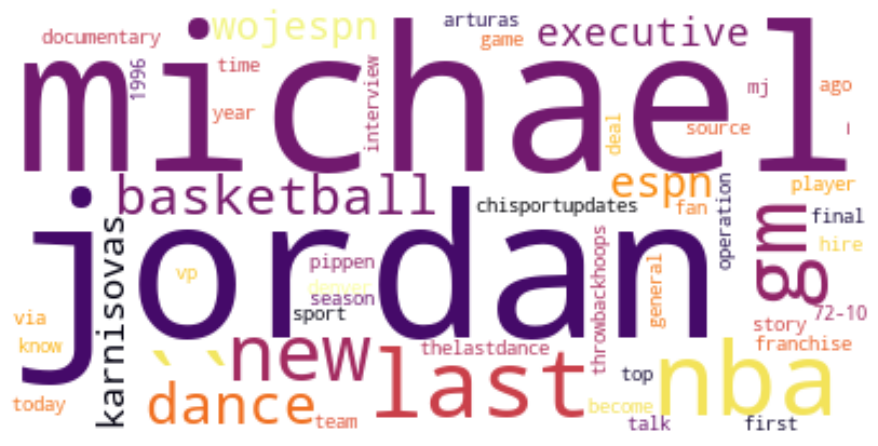

In [38]:
# Creating a dictionary containing the word and respective count -
#retrieve word and count from FreqDist tuples
most_common_count = [x[1] for x in word_freq.most_common(50)]
most_common_word = [x[0] for x in word_freq.most_common(50)]
top_50_dictionary = dict(zip(most_common_word, most_common_count))

# Getting the first 30 words for word cloud -
# plasma, magma, inferno, viridis, cividis
# best inferno :P
wordcloud = WordCloud(colormap = 'inferno', background_color = 'white')\
.generate_from_frequencies(top_50_dictionary)

# Plotting the word cloud of 50 words using matplotlib -
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
#plt.savefig('top_50_cloud.png')
plt.show()

In [31]:
df.head()

,doc_id,text,created,team,topic_modeling_text,sentiment_text,sentiment
1000,1245350215940542466,NBA's Marcus Smart Donating Blood Plasma After...,2020-04-01 14:00:03,Boston Celtics,NBA's Marcus Smart Donating Blood Plasma After...,nba marcus smart donating blood plasma beating...,0
1001,1245349792739459072,RT @CountryDumb662: No team ever has milked 1 ...,2020-04-01 13:58:22,Boston Celtics,RT @CountryDumb662: No team ever has milked 1 ...,countrydumb662 team ever milked title 08,1
1002,1245349570575466497,RT @DaveDuFourNBA: If the Celtics ever trade M...,2020-04-01 13:57:29,Boston Celtics,RT @DaveDuFourNBA: If the Celtics ever trade M...,davedufournba ever trade marcus smart going riot,0
1003,1245349500404879362,@SergioADippW Boston Celtics LA Dodgers Seattl...,2020-04-01 13:57:13,Boston Celtics,@SergioADippW Boston Celtics LA Dodgers Seattl...,sergioadippw la dodger seattle seahawks lewis ...,1
1004,1245349145822531585,RT @ShamsCharania: Boston Celtics guard Marcus...,2020-04-01 13:55:48,Boston Celtics,RT @ShamsCharania: Boston Celtics guard Marcus...,shamscharania guard marcus smart plan donate b...,1


In [49]:
# Create a id2word dictionary
token_dict = Dictionary(df['cleaned_text'])
print(len(token_dict))

16311


In [50]:
token_dict.filter_extremes(no_below=2, no_above=.99)

In [51]:
corpus = [token_dict.doc2bow(d) for d in df['cleaned_text']]

In [53]:
ldaModel = LdaMulticore(corpus=corpus, num_topics=5, id2word=token_dict, workers=12, passes=5)

In [58]:
# GEtting the topics - 
words = [re.findall(r'"([^"]*)"',t[1]) for t in ldaModel.print_topics()]
topics = [' '.join(t[0:10]) for t in words]
for id, t in enumerate(topics): 
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")

------ Topic 0 ------
nba last dance 72-10 jordan throwbackhoops player better 1996 thelastdance

------ Topic 1 ------
nba jordan michael thelastdance game final year video mj ballislife

------ Topic 2 ------
new wojespn gm marc eversley jordan become general manager michael

------ Topic 3 ------
jordan michael rodman dennis basketball nba top stay • time

------ Topic 4 ------
last dance michael espn jordan documentary basketball chisportupdates team kukoc



In [18]:
# Creating a dictionary to create bag of all words in the tweets -
text_dict = corpora.Dictionary(df['cleaned_text'])

# Creating bag of words -
tweets_bow = [text_dict.doc2bow(tweet) for tweet in df['cleaned_text']]


/Users/riteshsuhag/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
# Defining the number of topics -
k = 5
tweets_lda = LdaModel(tweets_bow,
                      num_topics = k,
                      id2word = text_dict,
                      random_state = 1,
                      passes=10)

/Users/riteshsuhag/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
# Looking at the topics -
tweets_lda.show_topics()

/Users/riteshsuhag/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.031*"jordan" + 0.025*"michael" + 0.021*"thelastdance" + 0.015*"team" + 0.014*"nba" + 0.012*"time" + 0.009*"watching" + 0.009*"best" + 0.008*"game" + 0.008*"ballislife"'),
 (1,
  '0.033*"year" + 0.033*"game" + 0.029*"72-10" + 0.028*"today" + 0.022*"hit" + 0.022*"ago" + 0.019*"know" + 0.019*"white" + 0.018*"kukoc" + 0.017*"deal"'),
 (2,
  '0.053*"last" + 0.048*"dance" + 0.044*"``" + 0.035*"jordan" + 0.029*"michael" + 0.029*"nba" + 0.020*"espn" + 0.017*"documentary" + 0.017*"championship" + 0.011*"run"'),
 (3,
  '0.041*"new" + 0.027*"—" + 0.025*"wojespn" + 0.025*"south" + 0.020*"karnisovas" + 0.019*"arturas" + 0.019*"executive" + 0.019*"basketball" + 0.018*"dennis" + 0.016*"rodman"'),
 (4,
  '0.026*"gm" + 0.018*"1996" + 0.017*"eversley" + 0.017*"pippen" + 0.016*"marc" + 0.016*"general" + 0.016*"manager" + 0.016*"rexchapman" + 0.016*"attendance" + 0.016*"beach"')]

In [21]:
# Compute Coherence Score
coherence_model = CoherenceModel(model=tweets_lda, texts=df['cleaned_text'], 
                                   dictionary=text_dict, coherence='c_v')
coherence_lda_model_base = coherence_model.get_coherence()
print('\nCoherence Score: ', coherence_lda_model_base)

/Users/riteshsuhag/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Coherence Score:  0.43397247242118747


In [25]:
pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim.prepare(tweets_lda, tweets_bow, dictionary=tweets_lda.id2word, R=10)
vis
pyLDAvis.save_html(vis, 'LDA_Visualization.html')


/Users/riteshsuhag/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.165953 -0.140811       1        1  23.733416
4     -0.072503  0.177825       2        1  22.861224
2     -0.230231 -0.057624       3        1  19.970777
3      0.177735  0.262667       4        1  19.409864
1      0.290952 -0.242057       5        1  14.024718, topic_info=       Term         Freq        Total Category  logprob  loglift
67     last  3156.000000  3156.000000  Default  10.0000  10.0000
63    dance  2888.000000  2888.000000  Default   9.0000   9.0000
16       ``  2848.000000  2848.000000  Default   8.0000   8.0000
124     new  2399.000000  2399.000000  Default   7.0000   7.0000
21   jordan  4575.000000  4575.000000  Default   6.0000   6.0000
..      ...          ...          ...      ...      ...      ...
914    coby   693.401110   694.195265   Topic5  -4.1037   1.9632
904    deal   728.197325   729.049550   Topic5  -4.0548   1.9632
129    year  1379.129855  1397.705285   Topic5  -3.4161   1.9510
435    game  1379.123441  1975.673873   Topic5  -3.4161   1.6049
169    know   787.073540  1239.720317   Topic5  -3.9770   1.5100

[89 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
196       3  0.998593       10-part
863       2  0.999524          1996
454       3  0.998667       1997-98
1033      5  0.999278         72-10
16        1  0.000351            ``
...     ...       ...           ...
6012      3  0.997017  zachlowe_nba
778       1  0.069187             —
778       2  0.000572             —
778       4  0.903431             —
778       5  0.027446             —

[111 rows x 3 columns], R=10, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 3, 4, 2])

In [ ]:
# ~~~~~~~~~~~~~~~~~~~~ HYPERPARAMETER TUNING ~~~~~~~~~~~~~~~~~~~~

/Users/riteshsuhag/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


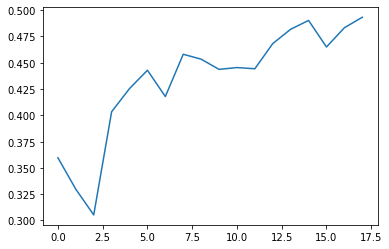

In [27]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values_topic = []
    model_list_topic = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=text_dict)
        model_list_topic.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values_topic.append(coherencemodel.get_coherence())
    return model_list_topic, coherence_values_topic

model_list_topic, coherence_values_topic = compute_coherence_values(dictionary=text_dict,
                                                        corpus=tweets_bow,
                                                        texts=df['cleaned_text'],
                                                        start=2, limit=20, step=1)

plt.plot(range(len(coherence_values_topic)),coherence_values_topic)
plt.show()

In [ ]:
pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim.prepare(best_model, tweets_bow, dictionary=tweets_lda.id2word, R=10)
pyLDAvis.save_html(vis, 'LDA_Visualization.html')

In [28]:
k = 4
tweets_lda = LdaModel(tweets_bow,
                      num_topics = k,
                      id2word = text_dict,
                      random_state = 1,
                      passes=10)

pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim.prepare(tweets_lda, tweets_bow, dictionary=tweets_lda.id2word, R=10)
vis

/Users/riteshsuhag/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.187992 -0.044553       1        1  38.099850
3      0.283311 -0.233863       2        1  24.932714
1     -0.236081 -0.049596       3        1  23.714573
2      0.140762  0.328013       4        1  13.252862, topic_info=              Term         Freq        Total Category  logprob  loglift
124            new  2382.000000  2382.000000  Default  10.0000  10.0000
67            last  3097.000000  3097.000000  Default   9.0000   9.0000
435           game  1930.000000  1930.000000  Default   8.0000   8.0000
63           dance  2834.000000  2834.000000  Default   7.0000   7.0000
230     basketball  1807.000000  1807.000000  Default   6.0000   6.0000
...            ...          ...          ...      ...      ...      ...
6291         sixer   582.010600   582.814120   Topic4  -4.2222   2.0196
2090            ya   441.523984   442.268066   Topic4  -4.4985   2.0193
4776      original   434.406778   435.150970   Topic4  -4.5147   2.0192
1947           es…   480.085361   480.914770   Topic4  -4.4148   2.0192
210   thelastdance   482.234923  1543.902649   Topic4  -4.4103   0.8573

[78 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
1033       2  0.042644   72-10
1033       3  0.957021   72-10
16         1  0.836395      ``
16         3  0.107562      ``
16         4  0.055760      ``
...      ...       ...     ...
129        2  0.006556    year
129        3  0.853711    year
12254      3  0.999404  yelled
778        1  0.089831       —
778        2  0.909823       —

[85 rows x 3 columns], R=10, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 2, 3])

In [39]:
pyLDAvis.disable_notebook()

/Users/riteshsuhag/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
